Construction d'une base de donnée systeme de controle reorganiser sous forme d'image 3 canaux (a,t,t+1) pour l'adapter au algorithme génératif de diffusion

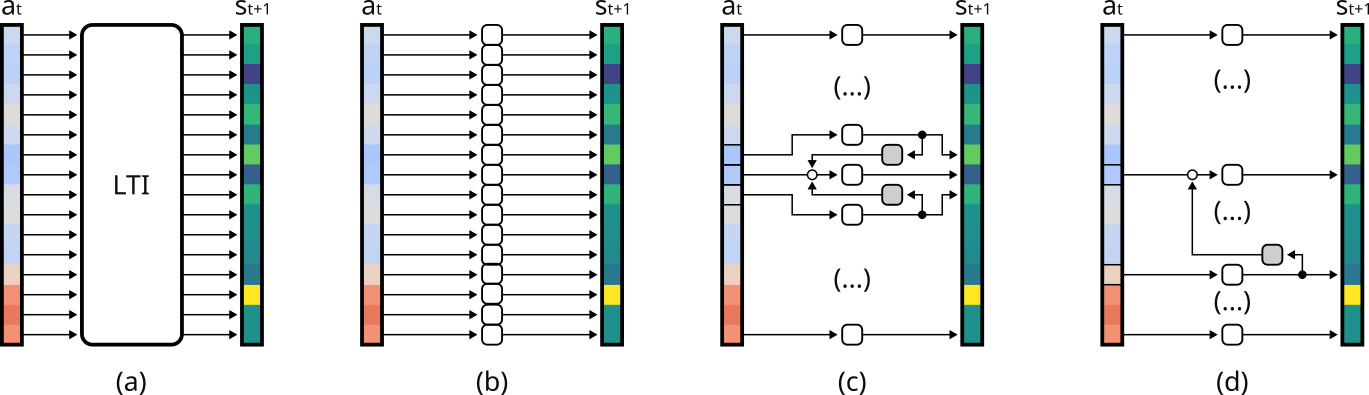

In [ ]:
!pip install diffusers[training] --quiet
!pip install datasets --quiet

In [1]:
import numpy as np, pylab as plt

from tqdm import tqdm, auto
from pathlib import Path
import os, pandas as pd

import scipy.ndimage as sm

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# setting device on GPU if available, else CPU --> for not ban
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dirpath = "/content/drive/MyDrive/Colab Notebooks/SetpointReinforcementLearning/DATA/"

### import dataset

------ Masquer cette partie

In [41]:
class CustomDataset(Dataset):
    def __init__(self, datapath, csv_file, train_file='train.zip'):
        self.metadata = pd.read_csv(datapath + csv_file)
        self.metadata["p_action"] = self.metadata["p_action"].str.replace("  ",",").str.replace(",,",",").apply(eval)
        self.metadata["p_state"] = self.metadata["p_state"].str.replace("  ",",").str.replace(",,",",").apply(eval)
        # # setting device on GPU if available, else CPU --> for not ban
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # import data & transform
        self.data = []
        all_data_zip = np.load(datapath + train_file) # 100 more faster !
        preprocess = transforms.Compose([transforms.Normalize([0.5], [0.5]),])
        for (i,row) in tqdm(self.metadata.iterrows(), total=self.metadata.shape[0]) :
          data = all_data_zip[row["file_name"]].astype(float)
          # scaling (channel)
          s, a = row['p_state'], row['p_action']
          data[[0,2,4]] = (data[[0,2,4]]/255)*(s[1]-s[0]) + s[0]
          data[[1,3]] = (data[[1,3]]/255)*(a[1]-a[0]) + a[0]
          # normalize (all channel)
          data = (data - data.min()) / (data.max() - data.min())
          # convert & standardize
          data = torch.tensor(data, dtype=torch.float).to(device)
          self.data += [preprocess(data)]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx] # change to iterableDataset to add pandas info

In [42]:
csv_file = 'metadata.csv'
data = CustomDataset(dirpath + "datafolder_train/", csv_file)

100%|██████████| 5292/5292 [00:06<00:00, 849.08it/s]


## Import tensorboard file (and see it)

https://www.tensorflow.org/tensorboard/dataframe_api?hl=fr

In [5]:
import tensorboard as tb
from tensorflow.python.summary.summary_iterator import summary_iterator

In [6]:
model_path = ["ddpm-spdl-32-classic/", "ddpm-spdl-32-setpoint/", "ddpm-spdl-32-setpoint-inverted/"]
experiment_id = ["events.out.tfevents.1710250977.6cfba84b2a51.952.0", "events.out.tfevents.1710253310.6cfba84b2a51.12063.0", "events.out.tfevents.1710325879.f20401a40322.2039.0"]

In [7]:
logs, loss = [], []
for m,id in zip(model_path, experiment_id):
  logs_, loss_ = [], []
  experiment = summary_iterator(dirpath + m + "logs/train_example/" + id)
  for e in experiment:
      logs_ += [e]
      for v in e.summary.value:
          if v.tag == 'loss' or v.tag == 'accuracy':
              loss_ += [v.simple_value]
  print(len(loss_))
  logs += [logs_]
  loss += [loss_]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


16550
16550
16550


In [8]:
df = pd.DataFrame(logs_)
print(df.shape)
df.head()

(49651, 1)


,0
0,"wall_time: 1710325879.5178297\nfile_version: ""..."
1,wall_time: 1710325883.1480467\nsummary {\n va...
2,wall_time: 1710325883.1481473\nsummary {\n va...
3,wall_time: 1710325883.1481912\nsummary {\n va...
4,wall_time: 1710325883.3267484\nstep: 1\nsummar...


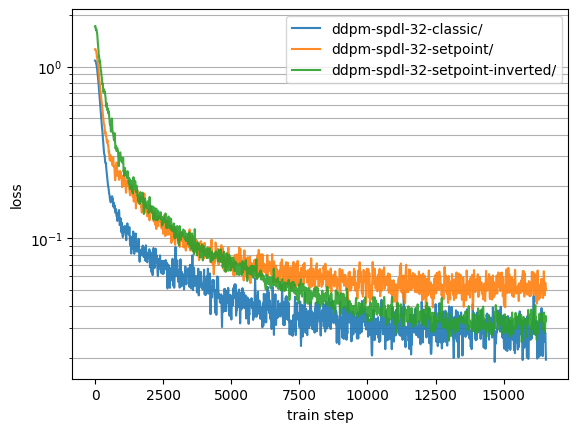

In [68]:
plt.grid(True, which='both', axis="y")
for l,m in zip(loss,model_path) :
  smooth = sm.gaussian_filter1d(l, 7)
  plt.semilogy(smooth, label=m, alpha=0.9)
  #plt.plot(np.log(smooth), label=m, alpha=0.9)
plt.ylabel("loss"); plt.xlabel("train step")
plt.legend(); plt.show()

## Test generative model (inference)

https://huggingface.co/docs/accelerate/usage_guides/checkpoint

https://huggingface.co/docs/diffusers/main/en/using-diffusers/using_safetensors

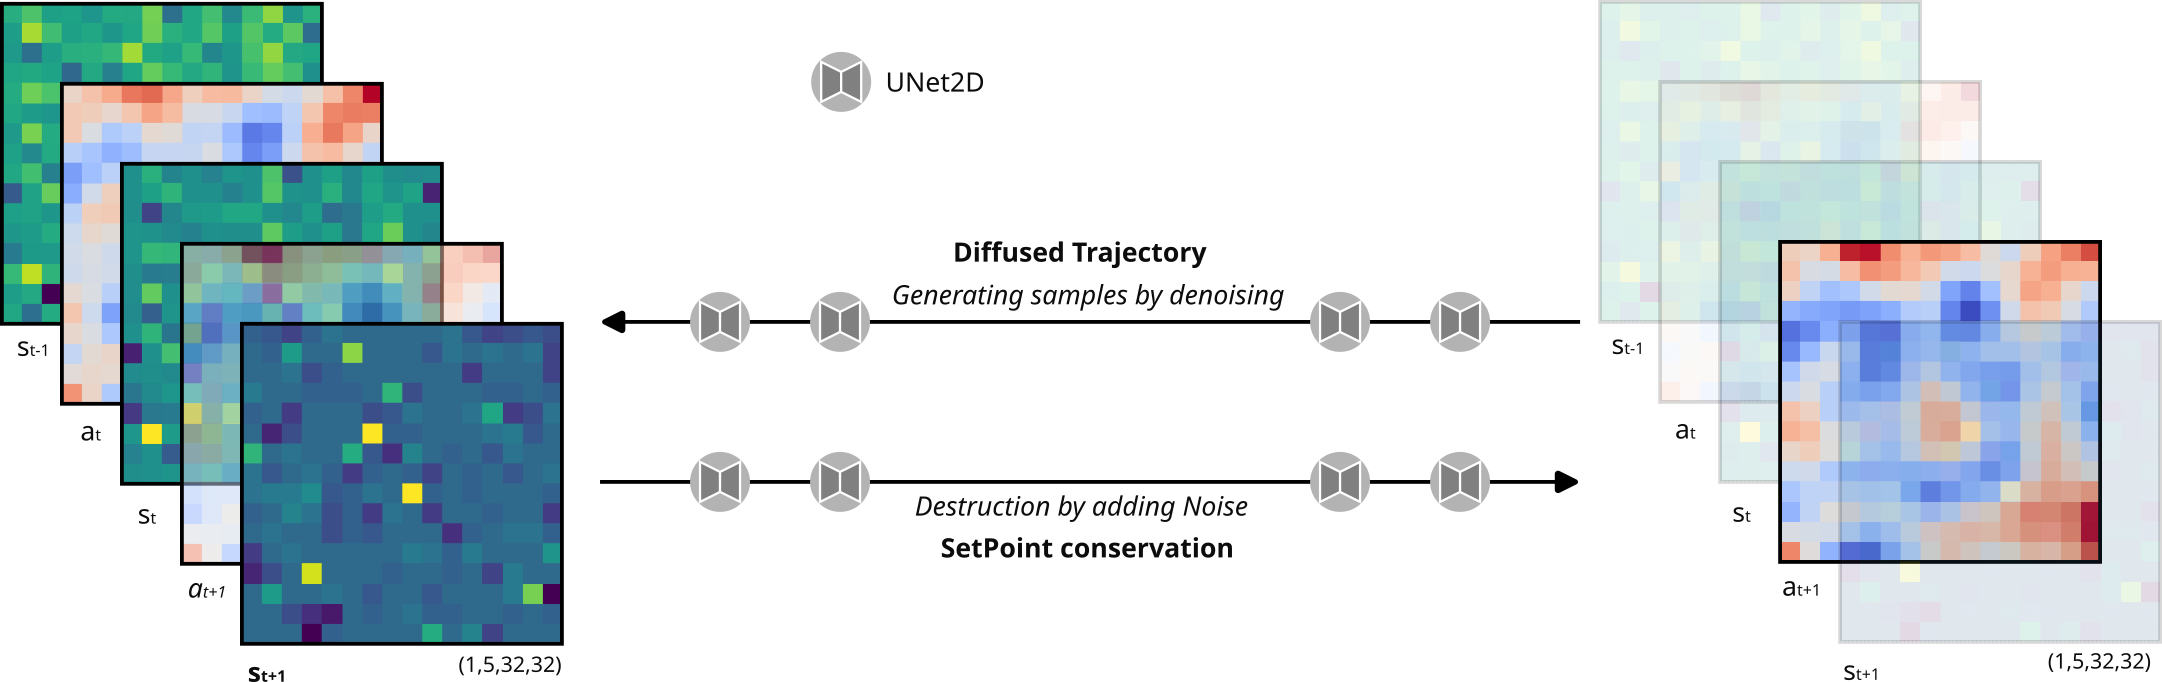

In [14]:
from diffusers import DiffusionPipeline

In [35]:
path = dirpath + model_path[0]
# Charger le modèle pré-entraîné avec SafeTensor
pipeline_classic = DiffusionPipeline.from_pretrained(path, use_safetensors=True)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
pipeline_classic

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.27.0",
  "_name_or_path": "/content/drive/MyDrive/Colab Notebooks/SetpointReinforcementLearning/DATA/ddpm-spdl-32-classic/",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [32]:
num_train_timesteps = torch.LongTensor([1000])

In [33]:
# Générer un bruit aléatoire (diffuseur)
random_noise = torch.randn(1, 5, 32, 32)  # Exemple de bruit aléatoire en format tensor

# Effectuer l'inférence pour générer une image à partir du bruit aléatoire
output_image = pipeline_classic.unet(random_noise, num_train_timesteps, return_dict=False)

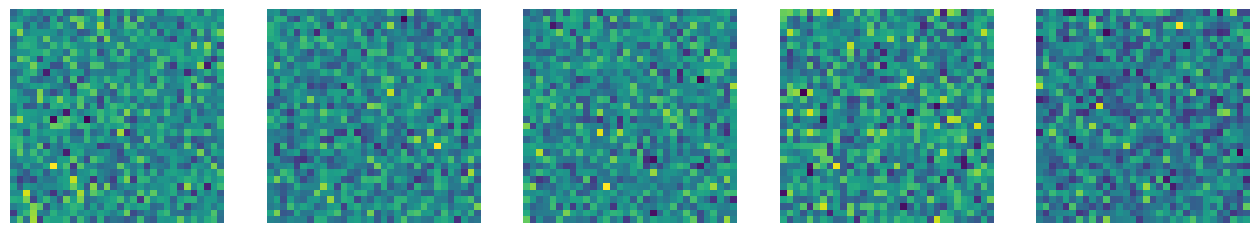

In [39]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for i, image in enumerate(output_image[0].cpu().detach().numpy()[0]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

### Test from dataset

In [43]:
train_batch_size = 16
train_dataloader = DataLoader(data, train_batch_size, shuffle=True)
sample = train_dataloader.dataset[0][None]

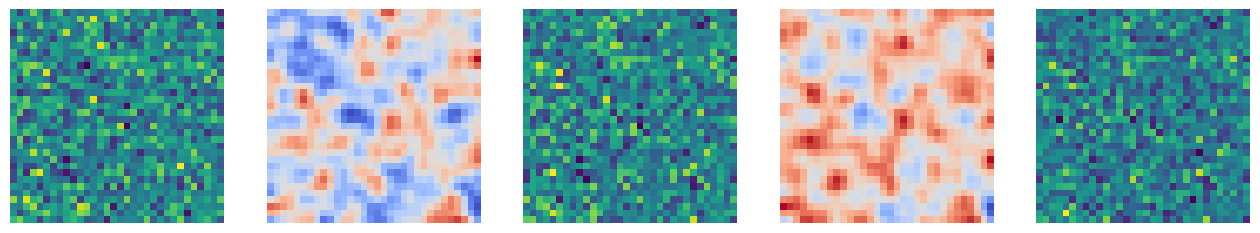

In [94]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for i, image in enumerate(sample.cpu().detach().numpy()[0]):
    if (i+1)%2 == 0 : axs[i].imshow(image, cmap='coolwarm')
    else : axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [45]:
output_image_sample = pipeline_classic.unet(sample, num_train_timesteps, return_dict=False)

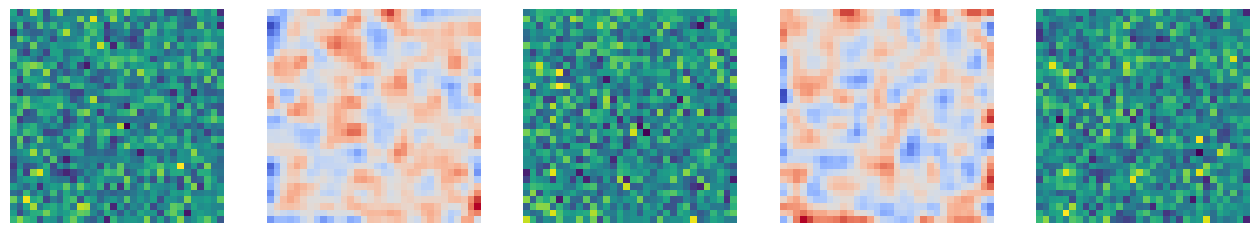

In [95]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for i, image in enumerate(output_image_sample[0].cpu().detach().numpy()[0]):
    if (i+1)%2 == 0 : image = sm.gaussian_filter(image,1.); axs[i].imshow(image, cmap='coolwarm')
    else : axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

## Generate timeline of diffuser environnement

In [79]:
# get a timeline of experiment
sample0 = data.metadata.file_name.str.contains("sample_0_")

In [ ]:
index = data.metadata.index[sample0].tolist()

In [88]:
subdata = np.concatenate([data.__getitem__(i)[None] for i in index])
subdata.shape

(98, 5, 32, 32)

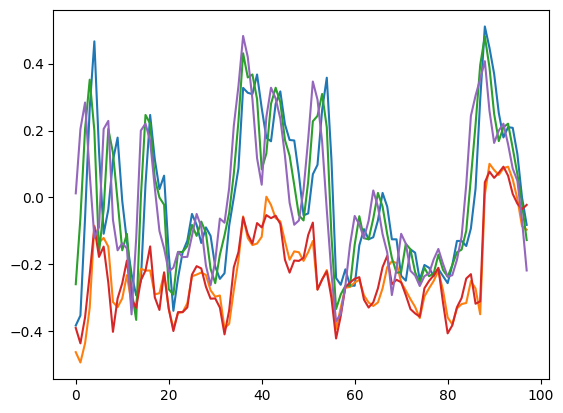

In [92]:
for i in range(5):
  plt.plot(subdata[:,i,16,16])
plt.show()

## Source :


https://www.reddit.com/r/StableDiffusion/comments/1581qjk/making_and_training_stable_diffusion_models_from/?rdt=36200

https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb

https://diffusion-planning.github.io/

https://huggingface.co/docs/diffusers/tutorials/basic_training

Attention : Stable diffusion est different de diffusion, car espace latent : https://arxiv.org/abs/2112.10752 (impossible from scratch, uniquement pretrained https://www.databricks.com/blog/stable-diffusion-2 )

ici, juste un UNet : https://arxiv.org/abs/1505.04597

https://github.com/opendilab/awesome-diffusion-model-in-rl

ici : Unconditional diffusion